#AerialWatch — Analysis & Model in Action
Authors:

*MobileNetV2 approach: Margarita Rincon Matamoros*

*CNN approach: Aung Aung*



**Project**

Aerial Watch is a computer vision model capable of determining whether an aerial drone image contains people or no people.

The goal is to create an efficient classifier suitable for real-time or near real-time applications, such as search-and-rescue drones, surveillance systems, and autonomous monitoring.

**GOAL**

Use supervised machine learning to classify drone images into two categories:

*   People
*   No_people

The model learns to recognize humans from above — even when people appear extremely small, partially occluded, or blended into complex outdoor environments.


## Research Question

**Can a lightweight deep learning model reliably detect the presence of people in aerial drone images?**

AerialWatch addresses a practical need in search-and-rescue and autonomous monitoring: identifying humans from a drone’s top-down or oblique viewpoint, where people may appear very small, partially hidden, or visually blended into complex outdoor environments.

The objective is to train a supervised machine learning model to classify each drone image into one of two categories:
- **people** — at least one visible person is present  
- **no_people** — no humans appear in the scene

This notebook evaluates how well the trained MobileNetV2 classifier generalizes to new, unseen drone images as compared to a CNN Model trained for the same purpose.


#Margarita
**MobileNetV2 Approach**

 I used a pretrained MobileNetV2 model and fine-tuned it for binary classification (people vs. no-people). Unlike our custom CNN, MobileNetV2 provides deeper feature representations from prior ImageNet training, enabling better generalization on limited drone data.

#Aung


**CNN Approach**

{}

In [ ]:
# Imports
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec

# packages for PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, random_split, Dataset, DataLoader, TensorDataset
import torchvision.models as models
torch.manual_seed(18);

In [ ]:
# For this project CUDA is recommended
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda


**Prep Data for model Training**


*   Normalize images. Because MobileNetV2 was trained on ImageNet Data, we need to use those values for normalization. Otherwise this is inneficient.
*   Image Augmentations. This would help improve model's generalization capabilities.

In [ ]:
IMG_SIZE = 224

# ImageNet normalization used by MobileNetV2
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Eval-only transformations (no augmentation)
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Paths
base = "./classification_dataset"

train_dir = f"{base}/train_output"
val_dir   = f"{base}/val_output"
test_dir  = f"{base}/test_output"

# Datasets (eval_tfms only)
train_ds = datasets.ImageFolder(train_dir, transform=eval_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

# Dataloaders
BATCH_SIZE = 32
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

class_names = val_ds.classes
print("Classes:", class_names)



Train Classes: ['no_people', 'people']
Val Classes: ['no_people', 'people']
Test Classes: ['no_people', 'people']


**Construct the Model**

We are using a V2 Model for this problem. The expectation is that this will perform better than a CNN created from scratch.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Number of output classes
N_CLASSES = 2

# -----------------------------
# Rebuild the MobileNetV2 Model
# -----------------------------
mobilenet = models.mobilenet_v2(
    weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
)


# Replacing classifier head (same as in training notebook)
mobilenet.classifier[1] = nn.Linear(1280, N_CLASSES)

# Move model to device
model = mobilenet.to(device)

# -----------------------------
# Load Saved Weights
# -----------------------------

# Path to saved weights inside repo
weights_path = "./models/mobilenet_final.pth"

state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

model.eval()   # Set to evaluation mode

print("Model loaded successfully from:", weights_path)



Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 216MB/s]


Epoch 1/20 - Train Loss: 0.3173, Train Correct: 3546/4041 - Test Loss: 0.2441, Test Correct: 522/570 Test Accuracy: 522/570 (91.58%)
Epoch 2/20 - Train Loss: 0.2240, Train Correct: 3668/4041 - Test Loss: 0.2713, Test Correct: 506/570 Test Accuracy: 506/570 (88.77%)
Epoch 3/20 - Train Loss: 0.2074, Train Correct: 3663/4041 - Test Loss: 0.2259, Test Correct: 515/570 Test Accuracy: 515/570 (90.35%)
Epoch 4/20 - Train Loss: 0.1937, Train Correct: 3723/4041 - Test Loss: 0.1473, Test Correct: 539/570 Test Accuracy: 539/570 (94.56%)
Epoch 5/20 - Train Loss: 0.1689, Train Correct: 3759/4041 - Test Loss: 0.1496, Test Correct: 539/570 Test Accuracy: 539/570 (94.56%)
Epoch 6/20 - Train Loss: 0.1617, Train Correct: 3776/4041 - Test Loss: 0.1777, Test Correct: 522/570 Test Accuracy: 522/570 (91.58%)
Epoch 7/20 - Train Loss: 0.1562, Train Correct: 3774/4041 - Test Loss: 0.1422, Test Correct: 534/570 Test Accuracy: 534/570 (93.68%)
Epoch 8/20 - Train Loss: 0.1539, Train Correct: 3784/4041 - Test Loss

**Asses Model Performance - Model Tested on New Images**

We collected about 60 images from the Internet and classified them into People / No People.

The goal is to see how the model performs on images different from the ones used training.

In [ ]:
# Read images from Folder and use the same parameters to prep them before using the model on them.

#web_images/pp
#web_images/no_pp

# Web images directory (relative path inside repo)
web_base = "./classification_dataset/web_data"   # same level as notebooks

# Remove unsupported formats (safe pure Python version)
valid_exts = [".jpg", ".jpeg", ".png"]

for root, dirs, files in os.walk(web_base):
    for fname in files:
        if not any(fname.lower().endswith(ext) for ext in valid_exts):
            os.remove(os.path.join(root, fname))

# Load images using the same eval transforms
web_ds = datasets.ImageFolder(web_base, transform=eval_tfms)
web_loader = DataLoader(web_ds, batch_size=32, shuffle=False)

web_class_names = web_ds.classes
print("Web Classes:", web_class_names)
print("Number of web images:", len(web_ds))


Web Classes: ['no_pp', 'pp']
Number of web images: 44


In [ ]:
#Run Model on Web Images
model.eval()  # evaluation mode

total_correct = 0
total_images = 0

# per-class stats for pp / no_pp
num_classes = len(web_class_names)
class_correct = [0] * num_classes
class_total   = [0] * num_classes

with torch.no_grad():
    for inputs, labels in web_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Overall
        total_correct += (preds == labels).sum().item()
        total_images  += labels.size(0)

        # Per-class
        for i in range(labels.size(0)):
            label = labels[i].item()
            if preds[i] == labels[i]:
                class_correct[label] += 1
            class_total[label] += 1

overall_acc = total_correct / total_images * 100
print(f"\nOverall accuracy on web images: {overall_acc:.2f}%")

for i, cname in enumerate(web_class_names):
    if class_total[i] > 0:
        acc_i = class_correct[i] / class_total[i] * 100
        print(f"  {cname}: {class_correct[i]}/{class_total[i]} "
              f"correct ({acc_i:.2f}%)")



Overall accuracy on web images: 84.09%
  no_pp: 13/18 correct (72.22%)
  pp: 24/26 correct (92.31%)


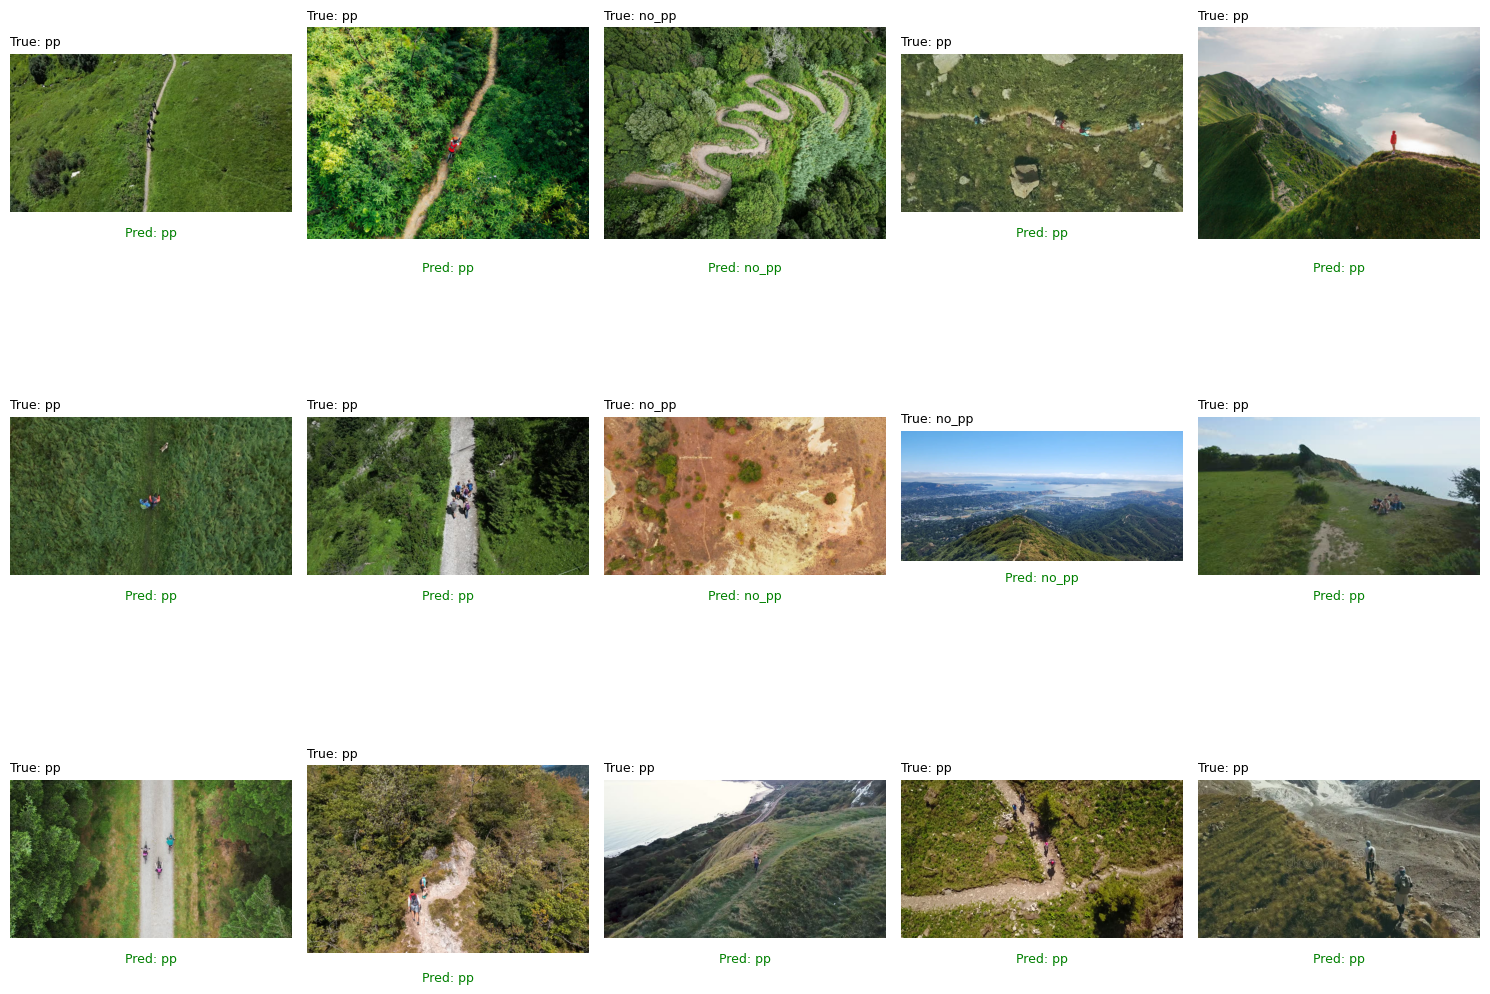

In [ ]:
# Model Performance

model.eval()

# Randomly pick 15 indices
random_indices = random.sample(range(len(web_ds)), 15)

plt.figure(figsize=(15, 12))

for idx, ds_idx in enumerate(random_indices):
    img_path, true_label = web_ds.samples[ds_idx]
    img = Image.open(img_path).convert("RGB")

    # Apply transforms
    input_tensor = eval_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred_label = torch.max(outputs, 1)
        pred_label = pred_label.item()

    # Check correctness
    correct = (pred_label == true_label)
    color = "green" if correct else "red"

    # Plot the image
    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.axis("off")

    # First line: True label (black)
    plt.title(f"True: {web_class_names[true_label]}", fontsize=9, loc="left")

    # Second line: Pred label (red/green)
    plt.text(
        0.5, -0.15,
        f"Pred: {web_class_names[pred_label]}",
        fontsize=9,
        color=color,
        ha="center",
        transform=plt.gca().transAxes
    )

plt.tight_layout()
plt.show()


# Observations

###Mago Approach

The fine-tuned MobileNetV2 model performs strongly on the curated test set, achieving around **94% accuracy**.  
When evaluated on a separate set of web images that were never seen during training, the model maintains an accuracy of about **84%**, demonstrating a reasonable ability to generalize to new environments.

Most of the errors occur in the form of **false positives**—predicting “people” in images where no people are present.  
In practical scenarios like search-and-rescue, this behavior is generally preferable to false negatives, since missing a person is far more costly than checking an empty area.

Overall, the model successfully answers our research question: it can detect the presence of people in aerial drone imagery with good accuracy, while leaving room for improvement in reducing false alarms and improving generalization on diverse real-world imagery.
